In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import beta
from scipy.special import beta as beta_point
import math
import random

%matplotlib inline

Valuing customer bases accurately has been a huge problem for many business and banks. While there are many approaches, this notebook will describe the method described in [this](https://faculty.wharton.upenn.edu/wp-content/uploads/2012/04/Fader_hardie_jim_07.pdf) article by Pete Fader and Bruce Hardie.

The motivation for using this approach comes from the over reliance on fitting generic equations (like polynomicals, logarithms, and lines) to customer survival curves and using the, to preict the future value of a companies customer base. One of the biggest problems with this is that it totally ignores heterogentity in customer bases. By ignoring heterogeneity can result in significant undervaluation of customer bases, outlined in more detail in [this](http://www.brucehardie.com/papers/022/fader_hardie_mksc_10.pdf) article (see page 89 for a good visualization of this undervaluation). Instead of using generic functions, in the article linked earlier, Fader and Hardie advocate to fit a distribution to model a customers propensity to churn, which will end up better account for customer heterogeneity (especially in a temporal setting).

There are two main cases which we have to account for, where we can observer the "death" of customers, or not. This can be thought of as contractual or non-contractural settings. First, we will investigate the contractual setting, and then move on to the non-contractual setting to show how fitting statistic distributions to churn data can be significanlty more accurate than other methods.

I initially learned this methedology in MKT426 at the Universtiy of Michigan Ross School of Business, taught by Prof. Eric Schwartz.

# Contractual Setting Valuation

First, we start in the contractual setting. In this case, we can observe when a customer "dies" based on when they stop renewing their contract. These are mainly reflected by subscription companies like Blue Apron, Hello Fresh, Netflix, and others.

In performing the analysis in this (and any other application of this methedology), it is important to split customers up into "cohorts" of customers that were acquired at the same time. For our purposes, we will assume that cohorts appear at discrete units in time (for instance, all customers gained in March are one cohort and they all started on March 1st).

## Data Setup

The data stored in survival_perc is the survival percent of a real cohort of Blue Apron customers gained at time t = 0. For instance, the first element in the array is 100% because all customers are surviving, at t = 1 the survival percent is 64.3% indicating a churn rate of 1 - .643 or .357 (35.7%).

We also define a number of other valuable metrics indlucde the cost to acquire a customer, on average, the average margin per order, and a discount rate.

In [47]:
survival_perc = [100.0, 64.3, 50.2, 41.5, 35.6, 31.1, 28.2, 25.4, 23.1, 21.0, 19.5, 19.5, 17.9]

CAC = 100 # Customer Acquisition Cost
AOR = 1.8  # Average Order Rate
RPO = 57.3 # Revenue per Order
CM = .26 # Contribution Margin
M = AOR * RPO * CM # Total Margin
WACC = 0.0153 # Discount Rate

## Data Imputation

First, we impute value indicative of the "ground truth" and add markers for time.

In [48]:
# We convert the values to percents
St_actual = list(map(lambda x : x / 100, survival_perc))
# Get the total number of periods being evaluated.
T = len(St_actual)
# Calculate retention rate, defined as S(t) / S(t - 1). This is indicative of the percent of customers that were retained from period t - 1 to t.
Rt_actual = [i / j for i, j in zip(St_actual[1:T], St_actual[0:(T-1)])]
# Create a dataframe of the ground truth, Rt_actual is None in period 0 because the cohort is brand new.
d = pd.DataFrame({
    "month": range(1, T + 1), 
    "St_actual": St_actual, 
    "Rt_actual": [None] + Rt_actual
})
# Define the length of the calibration period, periods 0 - 6 will be the "trian" set and 7 - 12 will be the test set
t_calib = 6


## Geometric Model

### Function Definitions

In [49]:
def G_rt_sse(logit_theta: float, d: pd.DataFrame) -> float:
    """
    Calculate Sum-of-Squared errors against the DataFrame d given a specific theta.

    @param logit_theta: The theta to calculate sse with passed in logathirmically.
    @param d: A ground truth DataFrame with a column Rt_actual, aginst which sse will be calculated.
    @returns: The sse for the geometric model, defined by theta, against DataFrame d.
    """
    # Inverse log to get raw theta
    theta = 1 / (1 + pow(-logit_theta, math.e))
    # Calculate sse for the geometric function
    return sum(np.power((1 - theta) - d["Rt_actual"].iloc[1:],2))

# Defining point calculations for the geometric model
G_survival = lambda gamma, delta, t: (1 - (gamma / (gamma + delta)))^t
G_churn = lambda gamma, delta, t: (gamma / (gamma + delta)) * G_survival(gamma, delta, t - 1)

### Calibration

In [50]:
# Minimize SSE, assuming theta starts at .1.
theta = minimize(G_rt_sse, math.log(.1 / (1 - .1)), d[0:t_calib + 1])
# De-normalize theta to get raw theta value of the geometric function
geom_theta_nls = 1 / (1 + pow(-theta["x"][0], math.e))

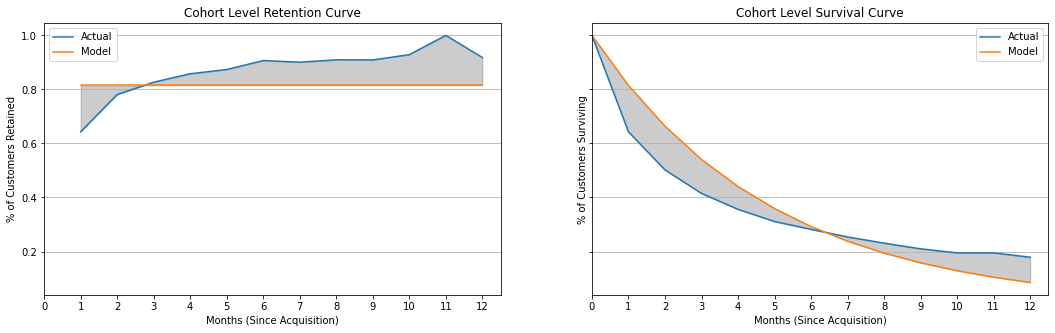

In [51]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True, figsize=(18, 5))

ax1.plot(d.index, d["Rt_actual"], label = "Actual")
ax1.axhline(1-geom_theta_nls, xmin = 1/12.5, xmax = 12/12.5, color = "C1", label="Model")
ax1.fill_between(d.index, d["Rt_actual"], 1 - geom_theta_nls, color = (0,0,0,0.2))
ax1.set_xlim(0, 12.5)
ax1.set_xticks(range(0, 13))
ax1.grid(axis = "y")
ax1.set_title("Cohort Level Retention Curve")
ax1.set_ylabel("% of Customers Retained")
ax1.set_xlabel("Months (Since Acquisition)")
ax1.legend()

ax2.plot(d.index, d["St_actual"], label="Actual")
ax2.plot(d.index, np.power(1 - geom_theta_nls, range(0, T)), label="Model")
ax2.fill_between(d.index, d["St_actual"], np.power(1 - geom_theta_nls, range(0, T)), color = (0,0,0,0.2))
ax2.set_xlim(0, 12.5)
ax2.set_xticks(range(0, 13))
ax2.grid(axis = "y")
ax2.set_title("Cohort Level Survival Curve")
ax2.set_ylabel("% of Customers Surviving")
ax2.set_xlabel("Months (Since Acquisition)")
ax2.legend()

Here we see that a geometric model assumes a constant retention rate (and likewise a constant churn rate), which the graph indicates is obviously not correct. Looking at the Cohort Level Survival Curve we can see the usual story with this model where it under-predicts churn in the early periods and over-estimates churn in the later periods. Why is this?

## Beta Geometric Model

After showing the inaccuracy of the geometric model, now let us investigate the significnat improvements a beta geometric model can offer.

### Function Definitions

In [52]:
def BG_rt(gamma: float, delta: float, t: int) -> float: 
    """
    Calculate the retention time t for a beta-geometric model described by gamma delta.
    
    @param gamma: The gamma parameter of the beta-geometric function.
    @param delta: The delta parameter of the beta-geometric function.
    @param t: The time at which to calculate retention.
    @returns: The retention rate at time t for BG(G, D)
    """
    return ((delta + t - 1) / (gamma + delta + t - 1))

def BG_rt_sse(params: list, d: pd.DataFrame) -> float:
    """
    Calculate sum-of-Squared errors against the DataFrame d given a beta-geomtric model defined by gamma and delta.

    @param params: A list of 2 floats list params[0] being gamma and params[1] being delta.
    @param d: A ground truth DataFrame with a column Rt_actual, aginst which sse will be calculated.
    @returns: The sse for the geometric model, defined by params, against DataFrame d.
    """
    # Un-normalize gamma and delta to raw values
    gamma = pow(params[0], math.e)
    delta = pow(params[1], math.e)
    # Get the values of all the allowable values to calculate sse for
    t = d.index[1:]
    Rt_actual = d["Rt_actual"].iloc[1:]
    # Get a list of all retentions predicted by the beta geometric function defined by gamma, delta
    pred = BG_rt(gamma, delta, t)
    # Calculate sse for the beta-geometric model against dataframe d
    return sum(pow(Rt_actual - pred, 2))

# Defining point calculations for the beta geometric model
BG_churn = lambda gamma, delta, t: beta_point(gamma + 1, delta + t - 1) / beta_point(gamma, delta) 
BG_survival = lambda gamma, delta, t: beta_point(gamma, delta + t) / beta_point(gamma, delta)

# Defining More Robust Model Takeaways
def BG_clv(gamma: float, delta: float, cf: float, disc: float, cac: float, t: int = 2000) -> pd.DataFrame:
    """
    Generate valuation data from beta-geometric input statistics.

    :param gamma: Gamma statistic of the beta model
    :param delta: Delta statistics of the beta model
    :param cf: Per purchase cash flow
    :param disc: Discount rate for time-value calculations
    :param cac: Cost of acquiring a customer in t = 0
    :param t: The number of periods to predict out
    """

    clv = pd.DataFrame({
        'cf': cf,
        'period': range(0, t),
        'st': BG_survival(gamma, delta, range(0, t)),
        'cac': cac
    })
    # Creating various model stats neccessary for later calculation
    clv['st_lag'] = clv["st"].shift(1) # Lagging s(t) by one so that we can calculate retention easily
    clv["rt"] = clv["st"] / clv["st_lag"]
    clv['st_lead'] = clv["st"].shift(-1)
    clv["pt"] = clv["st"] - clv["st_lead"]
    # Discounting Cashflows
    clv["disc_t"] = 1 / pow(1 + disc, clv["period"])
    clv["disc_cf"] = clv["cf"] * clv["disc_t"]
    # Cumulative: POTENTIAL discounted lifetimes and cumulative discounted cash flow values
    clv["disc_lifetime"] = np.cumsum(clv["disc_t"]) # cumulative discounting is "discounted lifetime"
    clv["expected_cumdisc_cf"] = clv["cf"] * np.cumsum(clv["disc_t"] * clv["st"]) - cac # E(CnV): expected customer value thru n periods
    clv["pav"] = round(clv["cf"] * clv["disc_lifetime"], 2) # post-acquisition value!
    clv["clv"] = round(clv["pav"] - cac, 2) # shift CLV to be actual CLV = PAV - CAC
    clv["pt_conv"] = [*clv["pt"][:-1], 1 - sum(clv["pt"][0:-1])]
    clv["e_clv"] = sum(clv["clv"] * clv["pt_conv"])
    clv["eclv_n"] = max(clv["expected_cumdisc_cf"]) - cac

    return clv

def BG_rlv(gamma: float, delta: float, cf: float, disc: float, past_t: int, t_end: int = 2000) -> pd.DataFrame:
    """
    Generate valuation data from beta-geometric input statistics after a certian time past_t.

    :param gamma: Gamma statistic of the beta model
    :param delta: Delta statistics of the beta model
    :param cf: Per purchase cash flow
    :param disc: Discount rate for time-value calculations
    :param cac: Cost of acquiring a customer in t = 0
    :param t: The number of periods to predict out
    """
    rlv = pd.DataFrame({
        'cf': cf,
        'period': range(past_t + 1, t_end + 1),
        'period_lag' : range(past_t, t_end)
    })

    rlv["st"] = BG_survival(gamma, delta, rlv["period"])
    rlv["st_past_t"] = BG_survival(gamma, delta, past_t)
    rlv["st_conditional"] = rlv["st"] / rlv["st_past_t"]
    rlv["pt_conditional"] = [1 - rlv["st_conditional"].iloc[0], *((rlv["st_conditional"] - rlv["st_conditional"].shift(-1))[0:-1])]
    rlv["discounted_RL"] = [0, *((1 / pow(1 + disc, rlv["period_lag"] - past_t - 1))[1:])]
    rlv["discounted_cf"] = rlv["cf"] * rlv["discounted_RL"]
    rlv["rlv"] = round(np.cumsum(rlv["discounted_cf"]), 2)

    rlv_sum_nest = rlv.groupby("rlv").agg({
        "rlv": ["size"],
        'pt_conditional': ["sum"]
    })

    rlv_sum = pd.DataFrame({"rlv": rlv_sum_nest.index, "num_exact_values": rlv_sum_nest["rlv"]["size"], "pt_conditional_sum": rlv_sum_nest["pt_conditional"]["sum"]})

    rlv_sum["pt_cond_conv"] = [*(rlv_sum["pt_conditional_sum"].iloc[0:-1]), 1 - sum(rlv_sum["pt_conditional_sum"].iloc[0:-1])]
    rlv_sum["erlv"] = sum(rlv_sum["rlv"] * rlv_sum["pt_cond_conv"])
    rlv_sum["past_t"] = past_t

    rlv_sum.reset_index(drop=True, inplace=True)

    return rlv_sum

### Calibration

In [53]:
# Minimize BG_rt_sse, starting with gamma, delta = 1, 1, using only t_calib periods
preds = minimize(BG_rt_sse, (1, 1), d[0:t_calib + 1])
# Undo the log of the params
gamma_nls = pow(preds["x"][0], math.e)
delta_nls = pow(preds["x"][1], math.e)

### Visualization

Text(0.5, 0, 'Churn Probability: ϴ')

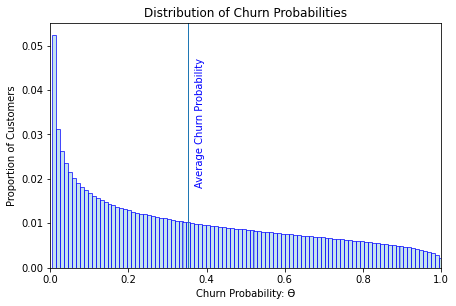

In [54]:
data = pd.DataFrame({
    "p": np.linspace(0, 1, 100), # Get a large set of numbers to generate prob curve
    # Create cdf estimates at all points between zero and one in p
    "cdf": beta.cdf(np.linspace(0, 1, 100), gamma_nls, delta_nls),
    # Calculate the difference between cdf(x_y) and cdf (x_(y+1)) to create a density distribution
    "cdf_diff": beta.cdf(np.linspace(0, 1, 100), gamma_nls, delta_nls) - np.append(0, beta.cdf(np.linspace(0, 1, 100), gamma_nls, delta_nls))[:-1]
})

fig, ax = plt.subplots(1, 1, figsize=(7, 4.5))

ax.bar(data["p"], data["cdf_diff"], width=1/98,
       color="lightblue", alpha=0.7, edgecolor="blue")
ax.axvline(gamma_nls / (gamma_nls + delta_nls), lw=1)
ax.text(gamma_nls / (gamma_nls + delta_nls) * 1.05,
        max(data["cdf_diff"]) * 0.35, "Average Churn Probability", rotation=90, color="blue")
ax.set_xlim(0, 1)
ax.title.set_text("Distribution of Churn Probabilities")
ax.set_ylabel("Proportion of Customers")
ax.set_xlabel("Churn Probability: \u03F4")

Here we see that the distribution of churn probabilites for HelloFresh is relatively advantageous, with a larger mass on the lower end, than the higher. From here, we can also tell that the average churn of the full cohort is about 35%.

In [55]:
# Calculate retention rates predicted by the beta distributions
Rt_model = [None, *BG_rt(gamma_nls, delta_nls, range(1, T))]
# Calculate survival, which can be defined as cumulative product of all retention rates
St_model = [1, *np.cumprod(Rt_model[1:])]
# Add modeled St and Rt to the data frame
d_est = d.assign(St_model = St_model, Rt_model = Rt_model)

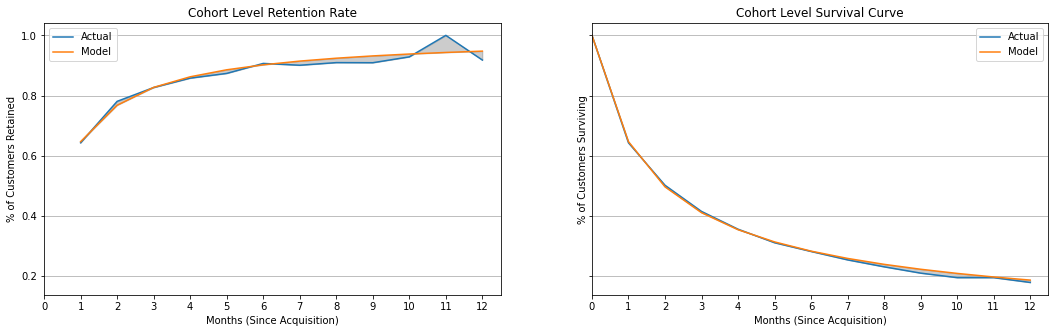

In [56]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True, figsize=(18, 5))

ax1.plot(d_est.index, d_est["Rt_actual"], label="Actual")
ax1.plot(d_est.index, d_est["Rt_model"], label="Model")
ax1.fill_between(d_est.index, d_est["Rt_actual"], d_est["Rt_model"], color = (0,0,0,0.2))
ax1.set_title("Cohort Level Retention Rate")
ax1.set_ylabel("% of Customers Retained")
ax1.set_xlabel("Months (Since Acquisition)")
ax1.set_xlim(0, 12.5)
ax1.set_xticks(range(0, 13))
ax1.grid(axis = "y")
ax1.legend()

ax2.plot(d_est.index, d_est["St_actual"], label = "Actual")
ax2.plot(d_est.index, d_est["St_model"], label = "Model")
ax2.fill_between(d_est.index, d_est["St_actual"], d_est["St_model"], color = (0,0,0,0.2))
ax2.set_title("Cohort Level Survival Curve")
ax2.set_ylabel("% of Customers Surviving")
ax2.set_xlabel("Months (Since Acquisition)")
ax2.set_xlim(0, 12.5)
ax2.set_xticks(range(0, 13))
ax2.grid(axis = "y")
ax2.legend()

Comparing this to the early geometric model, it is very obvious that the fit is significantly better. The cohort-level retention rate is able to increase and a decreasing rate and the survival curve is able to decease and a decreasing rate (again, why?). Obviously, it is impossible to perfectly model the real world (for instance the spike t = 11), however this model does an excellent job at evaluating the general trend.

### Value Findings

In [57]:
# Calculate information on cohort
clv_data = BG_clv(gamma_nls, delta_nls, M, WACC, CAC)
past_t = 4
rlv_data = BG_rlv(gamma_nls, delta_nls, M, WACC, past_t)
# Get stuff for proper graphing
xmax_both = max([*clv_data["clv"], *rlv_data["rlv"]])
ymax_both = max([*clv_data["pt_conv"], *rlv_data["pt_cond_conv"]])

#### CLV Distribution

The first type of analysis we can perform is on a random, individual customer. These conclusions focus mainly on the amount of value that a customer is likely to bring in. This is represented as Customer Lifetime Value (CLV) and can be represented in expectation and as a distribution of all possible values.

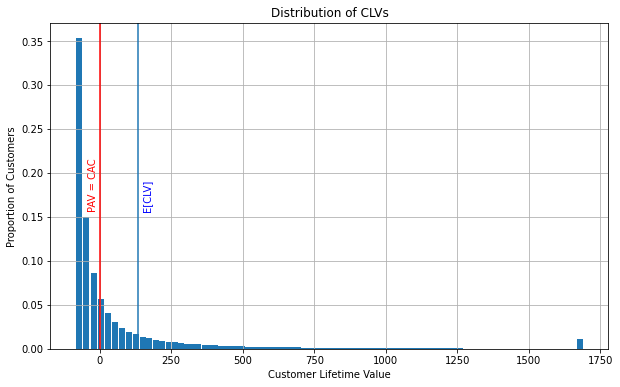

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

test = clv_data.groupby("clv")["pt_conv"].sum()

ax.bar(test.index, test, 20)
ax.axvline(0, color = "red")
ax.axvline(clv_data["e_clv"].mean())
ax.set_title("Distribution of CLVs")
ax.set_ylabel("Proportion of Customers")
ax.set_xlabel("Customer Lifetime Value")
ax.text(-40, ymax_both * 0.45, "PAV = CAC", rotation = 90, color = "red")
ax.text(clv_data["e_clv"].mean() * 1.1, ymax_both * 0.45, "E[CLV]", rotation = 90, color = "blue")
ax.grid()

In this case, we can see that the distribution is okay, but not great. Given that E(CLV) ~135 is greater than 0, it means that, in expectation, the business money. However, looking at the distribution, it is also obvious that a large proportion of customers (approximately 55%) will have a CLV less than 0. This means that, even though we net profit in total, this is due to the pull from the positive extreme of the cohort instead of the large majority of customers.

#### Cohort Valuation

In addition to customer valuation, we can also value cohorts of customers. These cohorts are made up of a random set of customers, of a fixed size, and all customers are acquired at the same time.

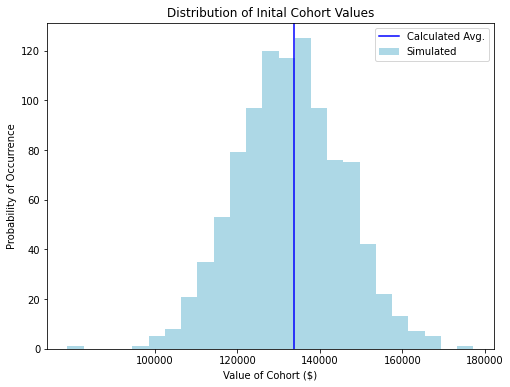

In [68]:
# Define cohort size and number of cohorts to simulate
n_sims = 1000
n_cohort = 1000
# Create a DataFrame with simulated customers
sim_vals = pd.DataFrame([random.choices(clv_data["clv"], clv_data["pt_conv"], k = n_cohort) for _ in range(n_sims)])
# Get information on the 1000 simulated cohorts
cohort_sim_totals = sim_vals.sum()
cohort_sim_avg = cohort_sim_totals.mean()
cohort_sim_std = cohort_sim_totals.std()
# Calculate information derived from model
clv_avg = clv_data["e_clv"].mean()
# Variance must be calculated specially because of the probability distribution
clv_var = sum(clv_data["clv"] * clv_data["clv"] * clv_data["pt_conv"]) - pow(clv_avg, 2)
cohort_calc_avg = clv_avg * n_cohort
cohort_calc_var = n_cohort * clv_var
cohort_calc_std = math.sqrt(cohort_calc_var)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.hist(cohort_sim_totals, bins = 25, color="lightblue", label = "Simulated")
ax.axvline(cohort_calc_avg, color="blue", label = "Calculated Avg.")
ax.set_xticks([100000, 120000, 140000, 160000, 180000])
ax.set_title("Distribution of Inital Cohort Values")
ax.set_xlabel("Value of Cohort ($)")
ax.set_ylabel("Probability of Occurrence")
ax.legend()

As the above histogram shows, the calculated cohort average is effectively the center point of the 1000 simulated cohort total values. This shows that the calculated summary stats are proper and match the simulated outcomes (within a margin of error). The histrogram also shows the variance inherint in the model where cohorts can come in well above or below the average value based on customer composition. As a side note, the histrogram exemplifies the central limit theorem where the sum of samples from any sort of distribution, in large enough quantities, will resemble a normal distribution even though the underlying distribution is non-normal.  

#### Customer Timing Insights

The last form of analysis that we can preform is on a customer (or cohort of customers) that have already renewed for t periods. This is an important evaluation because we have more information for this group (their past renewal behavior) than our initial cohort. Instead of finding the CLV, we find the Residual Lifetime Value (RLV) because, at this point, no customer is worth their lifetime value because some of their life has already passed. For both the customer and the cohort residual value analysis, we assume they have renewed for 4 periods.

##### Individual Customers

For an individual customers, we can first compare their new distribution of churn probability to their inital distribution. We can then compare the new RLV distribution to the old CLV distribution and observe if customers who have been retained for t periods are more or less valuable than they were at acqusition.

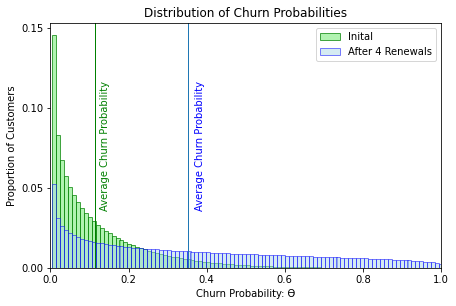

In [70]:
data = pd.DataFrame({
    "p": np.linspace(0, 1, 100),
    "cdf1": beta.cdf(np.linspace(0, 1, 100), gamma_nls, delta_nls),
    "cdf2": beta.cdf(np.linspace(0, 1, 100), gamma_nls, delta_nls + past_t),
    "cdf_diff1": (beta.cdf(np.linspace(0, 1, 100), gamma_nls, delta_nls) - np.append(0, beta.cdf(np.linspace(0, 1, 100), gamma_nls, delta_nls))[:-1]),
    "cdf_diff2": (beta.cdf(np.linspace(0, 1, 100), gamma_nls, delta_nls + past_t) - np.append(0, beta.cdf(np.linspace(0, 1, 100), gamma_nls, delta_nls + past_t))[:-1])
})

fig, ax = plt.subplots(1, 1, figsize = (7, 4.5))

ax.bar(data["p"], data["cdf_diff2"], width = 1/98, color = "lightgreen", alpha = 0.7, edgecolor = "green", label="Inital")
ax.bar(data["p"], data["cdf_diff1"], width = 1/98, color = "lightblue", alpha = 0.5, edgecolor = "blue", label = "After 4 Renewals")
ax.axvline(gamma_nls / (gamma_nls + delta_nls), lw = 1)
ax.text(gamma_nls / (gamma_nls + delta_nls) * 1.05, max(data["cdf_diff1"]) * 0.7, "Average Churn Probability", rotation = 90, color = "blue")
ax.axvline(gamma_nls / (gamma_nls + delta_nls + past_t), lw = 1, color = "green")
ax.text(gamma_nls / (gamma_nls + delta_nls + past_t) * 1.1, max(data["cdf_diff1"]) * 0.7, "Average Churn Probability", rotation = 90, color = "green")
ax.set_xlim(0, 1)
ax.title.set_text("Distribution of Churn Probabilities")
ax.set_ylabel("Proportion of Customers")
ax.set_xlabel("Churn Probability: \u03F4")
ax.set_yticks([0.0, 0.05, 0.1, 0.15])
ax.legend()

<BarContainer object of 2001 artists>

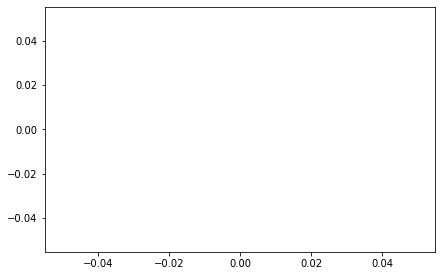

In [140]:
merged = rlv_data.merge(clv_data, left_on = "rlv", right_on = "pav", how="left")

fig, ax = plt.subplots(1, 1, figsize = (7, 4.5))

ax.bar(merged["pav"], merged["pt_conv"], width = 20, color = "lightblue", alpha = 0.5, edgecolor = "blue", label = "Inital")
ax.bar(merged["rlv"], merged["pt_cond_conv"], width = 20, color = "lightgreen", alpha = 0.5, edgecolor = "green", label = "After 4 Renewals")